# Recurrent Neural Network

## Part 1 - Data Preprocessing

### Importing the libraries

In [120]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [121]:
from datetime import datetime, timedelta
import tensorflow as tf
from keras.backend import clear_session
tf.compat.v1.reset_default_graph()
clear_session() 



### Importing the training set

In [122]:

import os
cwd = os.getcwd()
os.chdir(os.getcwd())

In [123]:
stock='ZEPAK'
dataset= pd.read_csv('{}\GPW_{}.csv'.format(cwd, stock))
iloc1=4
iloc2=5
delta=10

ostatnia_wartosc = dataset['Dzień'].iloc[-1]
dni= pd.DataFrame()
dni["Dzień"] = pd.to_datetime(dataset["Dzień"].iloc[-30:]).dt.strftime('%Y-%m-%d')
dni=dni["Dzień"].values.tolist()

ostatnia_wartosc = pd.to_datetime(ostatnia_wartosc).strftime('%Y-%m-%d')
ostatnia_wartosc= str(ostatnia_wartosc)



data= datetime.strptime(ostatnia_wartosc, '%Y-%m-%d')
data= data-timedelta(days = delta)
data= pd.to_datetime(data).strftime('%Y-%m-%d')

dataset_train1= dataset[dataset['Dzień'] < data]
training_set1 = dataset_train1.iloc[:,iloc1:iloc2].values
arr = training_set1

# Zmiana typu z string na int
for i in range(len(arr)):
    arr[i] = round(float(arr[i][0].replace(',', '.')), 3)
training_set = arr

dataset_test1 = dataset[dataset['Dzień'] >= data]

# print(len(dataset),len(training_set),len(dataset_test1))




In [124]:
dataset_test1

,Nazwa spółki,Kurs otwarcia,Kurs min,Kurs max,Kurs zamknięcia,Zmiana kursu w procent,Wolumen obrotu w szt,Lista transkacji,Wartość obrotu w tys,Dzień
2699,ZEPAK,"19,6200","20,0000","19,6000","19,9000","1,53",4476,64,"88,90",2023-08-25 00:00:00
2700,ZEPAK,"19,9000","20,0000","19,8000","19,8400","-0,30",5924,65,"118,00",2023-08-28 00:00:00
2701,ZEPAK,"19,9000","19,9200","19,6000","19,6000","-1,21",6796,77,"134,54",2023-08-29 00:00:00
2702,ZEPAK,"19,6000","19,7800","19,6000","19,6400","0,20",5849,67,"114,84",2023-08-30 00:00:00
2703,ZEPAK,"19,7800","19,9000","19,5000","19,6000","-0,20",7977,122,"157,15",2023-08-31 00:00:00
2704,ZEPAK,"19,5600","19,9000","19,5400","19,6000","0,00",10470,106,"205,77",2023-09-01 00:00:00
2705,ZEPAK,"19,6000","20,6000","19,6000","20,1500","2,81",17411,287,"351,03",2023-09-04 00:00:00


In [125]:
data

'2023-08-25'

In [126]:
ostatnia_wartosc


'2023-09-04'

### Feature Scaling

In [127]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)


### Creating a data structure with 60 timesteps and 1 output

In [128]:
X_train = []
y_train = []
X_train2 = []
timestep=120
for i in range(timestep,  len(training_set)):
    X_train.append(training_set_scaled[i-timestep:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [129]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


## Part 2 - Building and Training the RNN

### Importing the Keras libraries and packages

In [130]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout




### Initialising the RNN

In [131]:
regressor = Sequential()

### Adding the first LSTM layer and some Dropout regularisation

In [132]:
regressor.add(LSTM(units = 60, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

### Adding a second LSTM layer and some Dropout regularisation

In [133]:
regressor.add(LSTM(units = 60, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding a third LSTM layer and some Dropout regularisation

In [134]:
regressor.add(LSTM(units = 60, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding a fourth LSTM layer and some Dropout regularisation

In [135]:
regressor.add(LSTM(units = 60))
regressor.add(Dropout(0.2))

### Adding the output layer

In [136]:
regressor.add(Dense(units = 1))

### Compiling the RNN

In [137]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

### Fitting the RNN to the Training set

In [138]:
regressor.fit(X_train, y_train, epochs =100, batch_size = 32)

81/81 [==============================] - 13s 97ms/step - loss: 0.0138


## Part 3 - Making the predictions and visualising the results

### Getting the real stock price of 2017

In [139]:
# dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = dataset_test1.iloc[:, iloc1:iloc2].values
arr = real_stock_price
# Zmiana typu z string na int
for i in range(len(arr)):
    arr[i] = round(float(arr[i][0].replace(',', '.')), 3)
real_stock_price = arr


len(real_stock_price)

7

### Getting the predicted stock price of 2017

In [140]:
dataset_total = pd.concat((dataset_train1['Kurs zamknięcia'], dataset_test1['Kurs zamknięcia']), axis = 0)
arr = dataset_total
# Zmiana typu z string na int
for i in range(len(arr)):
    arr[i] = (float(arr[i].replace(',', '.')))
dataset_total = arr

inputs = dataset_total[len(dataset_total) - len(dataset_test1) - timestep:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)
X_test = []
for i in range(timestep, timestep + len(dataset_test1)):
    X_test.append(inputs[i - timestep:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# X_test_combined = X_test

# # Dopasowanie kształtu danych testowych
# X_test_combined = np.reshape(X_test_combined, (X_test_combined.shape[0], X_test_combined.shape[1], 1))

# Predykcja na danych testowych
predicted_test_prices = regressor.predict(X_test)
predicted_test_prices = sc.inverse_transform(predicted_test_prices)

# print(predicted_stock_price)
# # Predykcja na danych testowych
# # predicted_stock_price = regressor.predict(X_test)
# # predicted_stock_price = sc.inverse_transform(predicted_stock_price)


1/1 [==============================] - 1s 987ms/step


In [141]:
# Przewidywanie 10 dni do przodu
X_future = X_test.copy()
predicted_future_prices = []
for i in range(10):
    predicted_price = regressor.predict(X_future)
    predicted_future_prices.append(predicted_price[0, 0])
    X_future = np.roll(X_future, -1)


# Skalowanie odwrotne
predicted_future_prices = sc.inverse_transform(np.array(predicted_future_prices).reshape(-1, 1))

predicted_future_prices=predicted_future_prices.tolist()
# Wyświetlanie przewidywanych wartości
# pfp_zepak_20230711=[[20.34819],
#  [21.669386],
#  [22.290026],
#  [22.327923],
#  [22.439547],
#  [22.188908],
#  [22.116632],
#  [22.198847],
#  [22.482422],
#  [22.736067]]

# pfp_zepak_20230712=[[20.176626],
#  [22.483492],
#  [23.121317],
#  [22.927519],
#  [22.81228 ],
#  [23.133865],
#  [23.50026 ],
#  [23.68236 ],
#  [23.411707],
#  [23.229382]]



1/1 [==============================] - 0s 32ms/step


### Visualising the results

In [142]:
import itertools

ppp=[predicted_test_prices, predicted_future_prices]
# ppp2=[predicted_test_prices[:-1], pfp_zepak_20230711]
# ppp3=[predicted_test_prices[:-1], pfp_zepak_20230712]
ppp=list(itertools.chain.from_iterable(ppp))
# ppp2=list(itertools.chain.from_iterable(ppp2))
# ppp3=list(itertools.chain.from_iterable(ppp3))
# print(type(ppp3))
# print(type(ppp2))
print(type(ppp))


<class 'list'>


In [143]:
ostatnia_wartosc

'2023-09-04'

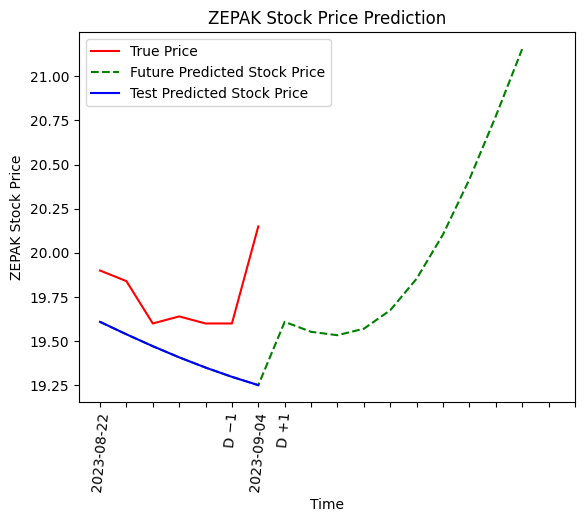

In [144]:

r=delta+9

lable=[]
ostatnia_wartosc=str(ostatnia_wartosc)
for i in range(r):
    lable.append(i)
    
lables=[]
for i in range(r):
    lables.append('')

lables[0]=str(dni[-delta])
lables[len(real_stock_price)-1]=str(ostatnia_wartosc)
lables[len(real_stock_price)-2]='D −1'
lables[len(real_stock_price)]='D +1'

ostatnia_wartosc = datetime.strptime(ostatnia_wartosc, '%Y-%m-%d').date()
# lables[len(ppp3)]=(ostatnia_wartosc+timedelta(days=10)).strftime('%Y-%m-%d')

plt.plot(real_stock_price, color = 'red', label = 'True Price')
# plt.plot(ppp3, color = 'grey', linestyle='dashed', alpha=1, label = 'Old D-2 Predicted Stock Price')
#plt.plot(ppp2, color = 'black', linestyle='dashed', alpha=0.2,  label = 'Old D-1 Predicted Stock Price')
plt.plot(ppp, color = 'green', linestyle='dashed', label = 'Future Predicted Stock Price')
plt.plot(predicted_test_prices, color = 'blue', label = 'Test Predicted Stock Price')
# plt.gca().invert_xaxis()
plt.xticks(ticks=lable, labels=lables, rotation=85)
plt.title('{} Stock Price Prediction'.format(stock))
plt.xlabel('Time')
plt.ylabel('{} Stock Price'.format(stock))
plt.legend()

regressor.save(r'C:\Users\Aleksander\Desktop\ZEPAK_RNN\{}_RNN_MODEL.h5'.format(stock))
plt.savefig(r'C:\Users\Aleksander\Desktop\ZEPAK_RNN\{}_prediction.png'.format(stock), bbox_inches="tight")
# plt.show()
